### Classic circular pupil Lyot coronagraph

NB mod from example in [docs.hcipy.org](https://docs.hcipy.org/0.4.0/tutorials/VortexCoronagraph/VortexCoronagraph.html)


We will simulate on-axis and off-axis images of stars through a classical Lyot  coronagraph (nee 1938ish).  We will trace through Figure 1 in my "coronagraphy for dummies" paper, (https://ui.adsabs.harvard.edu/abs/2001ApJ...552..397S/abstract).

We’ll start by importing all relevant libraries and setting up our pupil and focal grids. We’ll slightly oversize our pupil grid to more clearly see the effects of the coronagraph in the Lyot plane.



In [61]:
from hcipy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# For notebook animations
from matplotlib import animation
from IPython.display import HTML

In [62]:
mpl.rcParams['figure.dpi'] = 100

pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(8, 12)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

We start of by creating a circular aperture.We’ll use supersampling to evaluate this aperture to partially suppress sampling artefacts. We’ll study the undersizing of the circular Lyot stop.

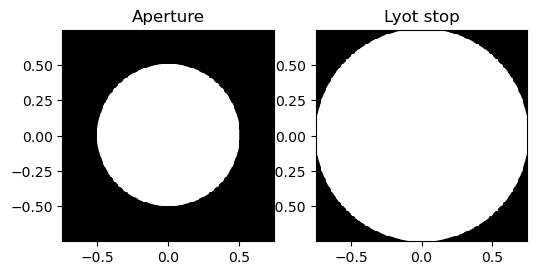

In [63]:
aperture = evaluate_supersampled(circular_aperture(1), pupil_grid, 4)
LYOT_UNDER = 1.5
lyot_mask = evaluate_supersampled(circular_aperture(LYOT_UNDER), pupil_grid, 4)

plt.subplot(1,2,1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1,2,2)
plt.title('Lyot stop')
imshow_field(lyot_mask, cmap='gray')
plt.show()

We can perform non-coronagraphic imaging by just using the Fraunhofer propagation defined above, to propagate the light from the pupil to the focal plane of our telescope.

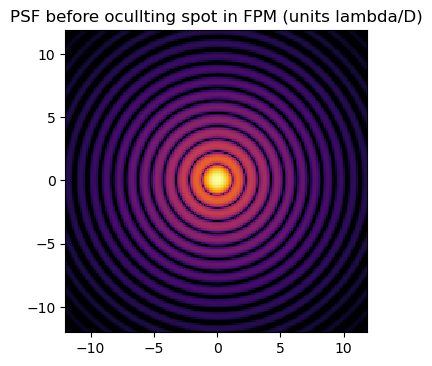

In [64]:
wf = Wavefront(aperture)
img_ref = prop(wf).intensity

plt.title('PSF before ocullting spot in FPM (units lambda/D)')
imshow_field(np.log10(img_ref / img_ref.max()), vmin=-5, cmap='inferno')
plt.show()

This shows the usual Airy pattern. We’ll now generate the coronagraph itself. It requires a pupil grid and the charge of the vortex. The vortex coronagraph object propagates light from the pupil plane to the Lyot plane.

Make a focal grid with enough samping for the focal plane mask:
32 pix per lam/D, and the exact size of the occulter grid we will use...

### Focal Plane Mask Size s = 5 in units of lambda/D

See "coronagraphy for dummies" paper, https://ui.adsabs.harvard.edu/abs/2001ApJ...552..397S/abstract (equation 4).

In [65]:
FPM_DIA = 5.0 # diameter of opaque stop in lambda/D, i.e. res elements
fpm_grid = make_focal_grid(32, FPM_DIA / 2)

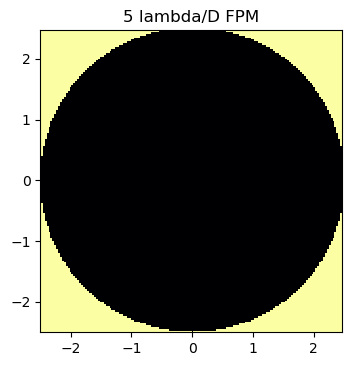

In [66]:
# Make the fpm itself
fpm = 1 - circular_aperture(FPM_DIA)(fpm_grid)
plt.title('5 lambda/D FPM')
imshow_field(fpm, vmin=0, cmap='inferno')

This is the focal plane mask grid.  The coronagraph propagator uses the Fourier trick in Soummer et al. 2007, “Fast computation of Lyot-style coronagraph propagation”, which works on FPMs with "compact support" - i.e. the occulter has finite extent in the focal plane.  This speeds up calculations tremendously.

In [67]:
# Perform the propagation...
coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

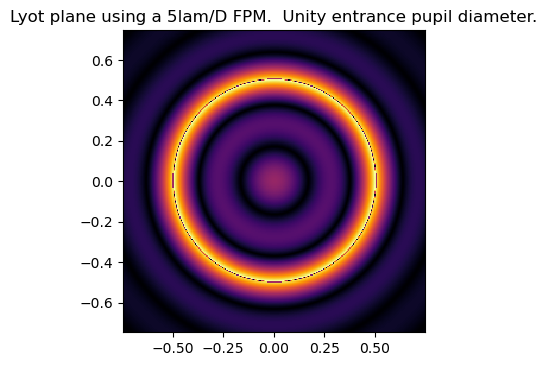

In [68]:
wf = Wavefront(aperture)
lyot_plane = coro(wf)
plt.title('Lyot plane using a 5lam/D FPM.  Unity entrance pupil diameter.')
imshow_field(np.power(lyot_plane.intensity / lyot_plane.intensity.max(), 0.5), cmap='inferno')
plt.show()

This Lyot pupil plane has a lower intensity in the central area of the Lyot pupil, but lot of of light around the (image of the) telescope pupil edge, both inside and outside the original pupil's edge.

Applying the oversized Lyot stop lets all the Airy rings outside the FPM through to the final image.  This is a bad coronagraph.  **The culprit is diffraction!  Just using a focal plane occulter didn't do much!!!!**

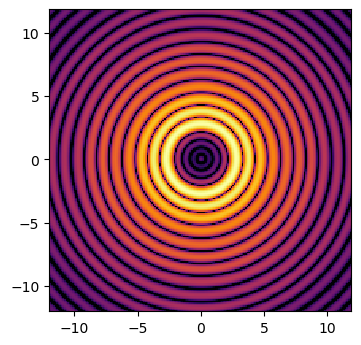

In [69]:
post_lyot_mask = lyot_stop(lyot_plane)
img = prop(post_lyot_mask).intensity

imshow_field(np.log10(img / img.max()), vmin=-3, vmax=0, cmap='inferno')
plt.show()

### This is a bad coronagraph.  
#### The culprit is diffraction!  Just using a focal plane occulter didn't do much!!!!
Applying the oversized Lyot stop (like not using an effective Lyot stop) lets all the Airy rings outside the FPM through to the final image.  


### Use a more optimized Lyot stop to make a better coronagraph:  
"Coronagraphy for dummies" paper, (https://ui.adsabs.harvard.edu/abs/2001ApJ...552..397S/abstract)...

Lyot diam ~ pupil diam - D/s

In [70]:
LYOT_UNDER = 1 - 1/5.0

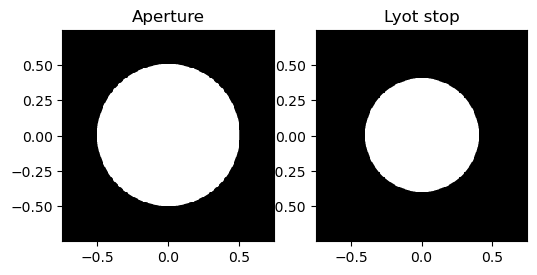

In [71]:
lyot_mask = evaluate_supersampled(circular_aperture(LYOT_UNDER), pupil_grid, 4)

plt.subplot(1,2,1)
plt.title('Aperture')
imshow_field(aperture, cmap='gray')
plt.subplot(1,2,2)
plt.title('Lyot stop')
imshow_field(lyot_mask, cmap='gray')
plt.show()

In [72]:
# Perform the propagation...
coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

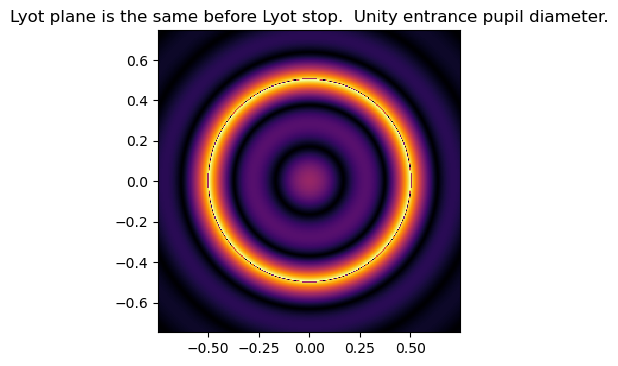

In [73]:
wf = Wavefront(aperture)
lyot_plane = coro(wf)
plt.title('Lyot plane is the same before Lyot stop.  Unity entrance pupil diameter.')
imshow_field(np.power(lyot_plane.intensity / lyot_plane.intensity.max(), 0.5), cmap='inferno')
plt.show()

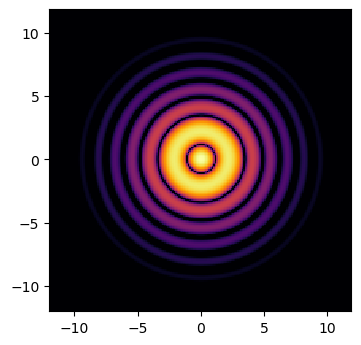

In [74]:
post_lyot_mask = lyot_stop(lyot_plane)
imgLC = prop(post_lyot_mask).intensity

imshow_field(np.log10(imgLC / imgLC.max()), vmin=-3, vmax=0, cmap='inferno')
plt.show()

In [75]:
print(imgLC.max() / img.max())


0.21277624881513751


In [76]:
print(imgLC.sum() / img.sum())

0.0783158360143752


### Max suppression (behind spot, all due to diffraction) 20%
### On-axis power leaked through coro 8%

## Exercise - work through a perfect coronagraph 
https://docs.hcipy.org/dev/tutorials/VortexCoronagraph/VortexCoronagraph.html
    
    Explain animations to yourself.
    
    What makes the vortex "perfect"?
    
    Tell us next class!